In [9]:
import os
import sys
from jax.config import config
import haiku as hk
import jax
from jax import numpy as jnp
import numpy as onp
import time
from jax.experimental.callback import rewrite
import tqdm

from bnn_hmc import data
from bnn_hmc import models
from bnn_hmc import nn_loss
from bnn_hmc import train_utils
from bnn_hmc import precision_utils

from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tpu_ip = "192.168.0.2"
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://{}:8470".format(tpu_ip)

In [3]:
net_fn = models.make_lenet_fn(10)
net_fn = jax.experimental.callback.rewrite(
  net_fn,
  precision_utils.HIGH_PRECISION_RULES)
net = hk.transform_with_state(net_fn)
train_set, test_set, _ = data.make_ds_pmap_fullbatch(name="cifar10")
log_likelihood_fn = nn_loss.xent_log_likelihood
log_prior_fn, log_prior_diff = (
  nn_loss.make_gaussian_log_prior(weight_decay=30))

update_fn, eval_fn, log_prob_and_grad_fn = (
  train_utils.make_hmc_update_eval_fns(
      net, train_set, test_set, log_likelihood_fn, log_prior_fn,
      log_prior_diff, target_accept_rate=0.9, step_size_adaptation_speed=0.))


In [5]:
# os.listdir('runs/burnin/burnin')
os.listdir('runs/burnin/seed_0_wd_30.0_stepsize_0.0001_trajlen_0.0002_niter15000')

['model_step_3.pt',
 'model_step_5.pt',
 'events.out.tfevents.1601009529.vm3-bnnhmc.12689.5.v2',
 'events.out.tfevents.1601009105.vm3-bnnhmc.11959.5.v2',
 'model_step_21.pt',
 'model_step_2.pt',
 'model_step_0.pt',
 'model_step_10.pt',
 'model_step_22.pt',
 'model_step_1.pt',
 'model_step_7.pt',
 'comand.sh',
 'model_step_11.pt',
 'model_step_19.pt',
 'model_step_9.pt',
 'model_step_25.pt',
 'events.out.tfevents.1601009236.vm3-bnnhmc.12212.5.v2',
 'model_step_15.pt',
 'model_step_20.pt',
 'model_step_14.pt',
 'model_step_13.pt',
 'model_step_12.pt',
 'model_step_6.pt',
 'model_step_24.pt',
 'model_step_18.pt',
 'model_step_4.pt',
 'events.out.tfevents.1601009328.vm3-bnnhmc.12440.5.v2',
 'model_step_16.pt',
 'model_step_17.pt',
 'events.out.tfevents.1601008985.vm3-bnnhmc.11729.5.v2',
 'model_step_8.pt',
 'model_step_26.pt',
 'model_step_23.pt']

In [85]:
formatstr = 'runs/burnin/burnin/seed_{}_wd_30.0_stepsize_0.0001_trajlen_0.3_niter15000'
# formatstr = 'runs/lenet/seed_{}_wd_30.0_stepsize_0.0001_trajlen_0.3_niter15000/'

In [98]:
all_probs = []
for seed in range(1, 3):
    current_dir = formatstr.format(seed)
    chain_probs = []
    for ckpt_name in tqdm.tqdm(os.listdir(current_dir)):
        if train_utils.name_is_checkpoint(ckpt_name):
            full_name = os.path.join(current_dir, ckpt_name)
            params, net_state, _, _, _, _, _ = (
                train_utils.load_checkpoint(full_name))

            probs = nn_loss.pmap_get_softmax_predictions(
                net, params, net_state, test_set, 1, False)
            chain_probs.append(onp.asarray(probs))
            
            preds = onp.argmax(probs, axis=-1)[:, 0]

            
            acc = (preds == test_set[1]).mean(axis=(0, 1))
            print(acc)
            
    chain_probs = onp.array(chain_probs)[:, :, 0]
    all_probs.append(chain_probs)
#     break

  5%|▌         | 2/40 [00:00<00:04,  8.50it/s]

0.7108
0.71779996


  8%|▊         | 3/40 [00:00<00:04,  8.10it/s]

0.7188


 12%|█▎        | 5/40 [00:00<00:05,  6.18it/s]

0.7186
0.7126


 18%|█▊        | 7/40 [00:01<00:04,  6.99it/s]

0.70949996
0.71779996


 22%|██▎       | 9/40 [00:01<00:04,  7.57it/s]

0.7186
0.7188


 28%|██▊       | 11/40 [00:01<00:03,  8.09it/s]

0.6906
0.71779996


 32%|███▎      | 13/40 [00:01<00:02,  9.57it/s]

0.71779996
0.7186


 42%|████▎     | 17/40 [00:01<00:02, 10.63it/s]

0.7188
0.7186


 48%|████▊     | 19/40 [00:02<00:02, 10.02it/s]

0.71779996
0.7186


 52%|█████▎    | 21/40 [00:02<00:02,  9.43it/s]

0.7186
0.7186


 57%|█████▊    | 23/40 [00:02<00:01,  9.22it/s]

0.7188
0.7186


 62%|██████▎   | 25/40 [00:02<00:01,  9.28it/s]

0.7186
0.7188


 68%|██████▊   | 27/40 [00:03<00:01,  8.67it/s]

0.7188
0.71779996


 72%|███████▎  | 29/40 [00:03<00:01, 10.04it/s]

0.71779996
0.71779996


 78%|███████▊  | 31/40 [00:03<00:00,  9.27it/s]

0.7186
0.7186


 85%|████████▌ | 34/40 [00:03<00:00,  8.90it/s]

0.71779996
0.7186


 90%|█████████ | 36/40 [00:04<00:00,  8.41it/s]

0.7186
0.71779996


 95%|█████████▌| 38/40 [00:04<00:00,  8.24it/s]

0.7186
0.7186


  0%|          | 0/40 [00:00<?, ?it/s]

0.7186
0.7188


  5%|▌         | 2/40 [00:00<00:05,  7.46it/s]

0.70879996
0.7172


 10%|█         | 4/40 [00:00<00:04,  7.43it/s]

0.72389996
0.7258


 15%|█▌        | 6/40 [00:00<00:04,  7.07it/s]

0.69699997
0.5804


 22%|██▎       | 9/40 [00:01<00:03,  7.81it/s]

0.7129
0.7258


 28%|██▊       | 11/40 [00:01<00:03,  7.52it/s]

0.72389996
0.6239


 35%|███▌      | 14/40 [00:01<00:02,  9.08it/s]

0.71599996
0.7175


 40%|████      | 16/40 [00:01<00:02,  8.23it/s]

0.7194
0.72209996


 45%|████▌     | 18/40 [00:02<00:02,  7.72it/s]

0.7169
0.71999997


 50%|█████     | 20/40 [00:02<00:02,  7.68it/s]

0.71999997
0.71529996


 55%|█████▌    | 22/40 [00:02<00:02,  7.90it/s]

0.71639997
0.72389996


 60%|██████    | 24/40 [00:02<00:02,  7.61it/s]

0.7194
0.7172


 65%|██████▌   | 26/40 [00:03<00:01,  7.20it/s]

0.7141
0.72209996


 72%|███████▎  | 29/40 [00:03<00:01,  7.68it/s]

0.7172
0.7211


 78%|███████▊  | 31/40 [00:03<00:01,  7.68it/s]

0.71599996
0.72099996


 82%|████████▎ | 33/40 [00:04<00:00,  7.39it/s]

0.7177
0.71669996


 88%|████████▊ | 35/40 [00:04<00:00,  7.25it/s]

0.71529996
0.71529996


 92%|█████████▎| 37/40 [00:04<00:00,  7.21it/s]

0.71999997
0.72679996


 98%|█████████▊| 39/40 [00:04<00:00,  7.08it/s]

0.71919996
0.72099996


100%|██████████| 40/40 [00:05<00:00,  7.83it/s]

0.7285


In [99]:
preds.shape

(8, 1250)

In [100]:
def get_ens_probs(chain_probs, n_burnin=0):
    probs = onp.cumsum(chain_probs[n_burnin:], axis=0) 
    probs /= onp.arange(1, len(chain_probs[n_burnin:])+1)[:, None, None, None]
    return probs

all_ens_probs = [
    get_ens_probs(chain_probs, n_burnin=5) for 
    chain_probs in all_probs]

In [101]:
all_ens_probs = onp.concatenate(all_ens_probs)
all_ens_preds = onp.argmax(all_ens_probs, -1)

In [102]:
ens_accs = (all_ens_preds == test_set[1][None, :]).mean(axis=(1, 2))

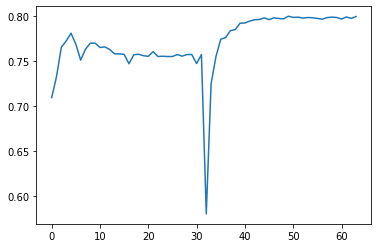

In [103]:
plt.plot(ens_accs)

In [22]:
all_chain_final_probs = onp.concatenate([chain_ens_probs[-1][None, :] for chain_ens_probs in all_ens_probs])

In [24]:
all_ens_probs[0].shape

(27, 8, 1250, 10)

In [15]:
all_chain_ens_final_probs = get_ens_probs(all_chain_final_probs)

In [16]:
all_chain_ens_final_preds = onp.argmax(all_chain_ens_final_probs, -1)

In [17]:
ens_accs = (all_chain_ens_final_preds == test_set[1][None, :]).mean(axis=(1, 2))

In [18]:
probs.shape

(8, 1, 1250, 10)

In [19]:
test_set[1].shape

(8, 1250)

In [20]:
ens_accs

DeviceArray([0.1153], dtype=float32)

Text(0, 0.5, 'accuracy')

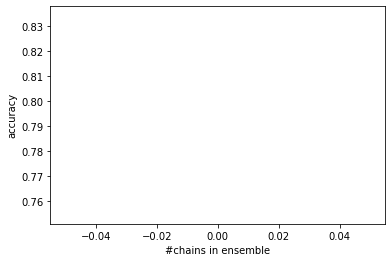

In [56]:
plt.plot(ens_accs)
plt.xlabel("#chains in ensemble")
plt.ylabel("accuracy")

In [57]:
ens_accs = (ens_preds == test_set[1][None, :]).mean(axis=(1, 2))

NameError: name 'ens_preds' is not defined

Text(0, 0.5, 'accuracy')

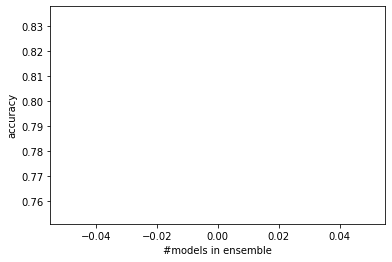

In [58]:
plt.plot(ens_accs)
plt.xlabel("#models in ensemble")
plt.ylabel("accuracy")

In [ ]:
ens_accs = [(onp.argmax(preds[:, 0], axis=-1) == test_set[1]).mean()]

In [24]:
np.asarray(preds).shape

(8, 1, 1250, 10)

In [9]:
(jnp.argmax(preds[:, 0], axis=-1) == test_set[1]).mean()

DeviceArray(0.70019996, dtype=float32)

In [25]:
test_set[1].shape

(8, 1250)

In [ ]:
os.listdir("lenet_runs/lenet/refactored/")